# Notebook per Predicció de Matèria Seca (MS) en Patates

Aquest notebook entrena una xarxa neuronal per predir el percentatge de 
matèria seca a partir de les característiques de color i NIR de les patates.

Columnes del dataset:
- id_mostra: identificador únic
- ruta_imatges: ruta a la imatge
- color_promig_R, color_promig_G, color_promig_B: colors mitjans RGB
- desviació_R, desviació_G, desviació_B: desviacions estàndard dels canals
- canal_NIR: valor del canal infraroig proper
- MS_experimental: percentatge de matèria seca (TARGET)
- lot: identificador del lot
- data: data de captura


## 1. IMPORTACIÓ DE LLIBRERIES


In [1]:
import os
import sys
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuració per reproducibilitat
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# Comprovar disponibilitat de GPU

print("=" * 70)
print("INFORMACIÓ DEL SISTEMA")
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA disponible (built with): {tf.test.is_built_with_cuda()}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# Verificar si TensorFlow pot veure la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ GPU detectada: {gpus}")
    for gpu in gpus:
        print(f"  - {gpu}")
    # Configurar memòria dinàmica (recomanat)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("  ✓ Memòria dinàmica configurada")
    except RuntimeError as e:
        print(f"  ✗ Error configurant memòria: {e}")
else:
    print("\n✗ No s'ha detectat cap GPU")
    print("  El model s'entrenarà amb CPU (més lent)")
print("=" * 70)

INFORMACIÓ DEL SISTEMA
TensorFlow version: 2.10.0
CUDA disponible (built with): True
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  ✓ Memòria dinàmica configurada


## 2. CÀRREGA I EXPLORACIÓ DE DADES


In [ ]:
# Definir rutes
current_path = Path().resolve()
TARGET_ROOT_NAME = "potato-dry-matter-optics-ml"

while current_path.name != TARGET_ROOT_NAME and current_path.parent != current_path:
    current_path = current_path.parent

if current_path.name != TARGET_ROOT_NAME:
    raise RuntimeError(
        f"No s'ha trobat la carpeta '{TARGET_ROOT_NAME}' pujant des del directori actual: {Path().resolve()}"
    )

project_root = current_path
sys.path.append(str(project_root))

RUTA_DATASET = os.path.join(project_root, "data/input/training/training_set_dummy_2.csv")
RUTA_OUTPUT = os.path.join(project_root, "data/output/test_run_dummy_2")

# Si el directori ja existeix, l'esborrem completament
if os.path.exists(RUTA_OUTPUT):
    shutil.rmtree(RUTA_OUTPUT)

# Crear directori d'output si no existeix
os.makedirs(RUTA_OUTPUT, exist_ok=True)
print(f"Directori d'output: {RUTA_OUTPUT}")

# Carregar les dades
df = pd.read_csv(RUTA_DATASET, sep = ',', na_filter=False , index_col = 0)

print("\n=== INFORMACIÓ DEL DATASET ===\n")
df.info()
print(f"\n\nPrimeres 5 files:")
df.head()

Directori d'output: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2

=== INFORMACIÓ DEL DATASET ===

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ruta_imatges     200 non-null    object 
 1   color_promig_R   200 non-null    float64
 2   color_promig_G   200 non-null    float64
 3   color_promig_B   200 non-null    float64
 4   desviació_R      200 non-null    float64
 5   desviació_G      200 non-null    float64
 6   desviació_B      200 non-null    float64
 7   canal_NIR        200 non-null    float64
 8   MS_experimental  200 non-null    float64
 9   lot              200 non-null    object 
 10  data             200 non-null    object 
dtypes: float64(8), object(3)
memory usage: 18.8+ KB


Primeres 5 files:


,ruta_imatges,color_promig_R,color_promig_G,color_promig_B,desviació_R,desviació_G,desviació_B,canal_NIR,MS_experimental,lot,data
id_mostra,,,,,,,,,,,
1,data/images/SYN_1.png,138.919716,121.589697,91.427565,13.977938,11.631688,9.612858,0.714286,19.797288,L3,2025-03-10
2,data/images/SYN_2.png,157.249851,133.508205,97.001654,12.510900,10.345701,8.747020,0.740060,21.859530,L1,2025-03-01
3,data/images/SYN_3.png,146.781426,123.354116,92.357001,13.587597,11.358019,9.084458,0.721033,20.243152,L3,2025-03-10
4,data/images/SYN_4.png,171.855305,142.835859,108.119266,10.471117,9.176817,7.259124,0.767844,23.568626,L2,2025-03-05
5,data/images/SYN_5.png,169.189834,139.995277,103.950105,9.763901,8.484092,7.074754,0.762226,22.992561,L2,2025-03-05


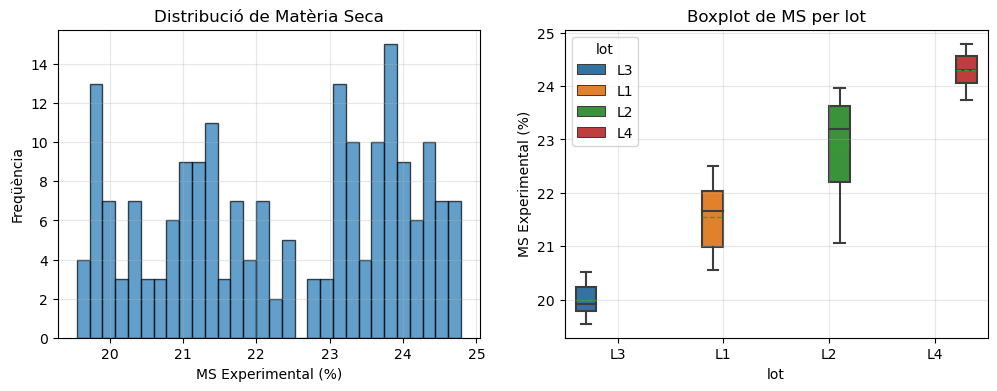

In [4]:
# Visualització de la distribució de MS
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['MS_experimental'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('MS Experimental (%)')
plt.ylabel('Freqüència')
plt.title('Distribució de Matèria Seca')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='lot', y='MS_experimental', hue='lot', showmeans=True, meanline=True)
plt.xlabel('lot')
plt.ylabel('MS Experimental (%)')
plt.title('Boxplot de MS per lot')
plt.grid(alpha=0.3)

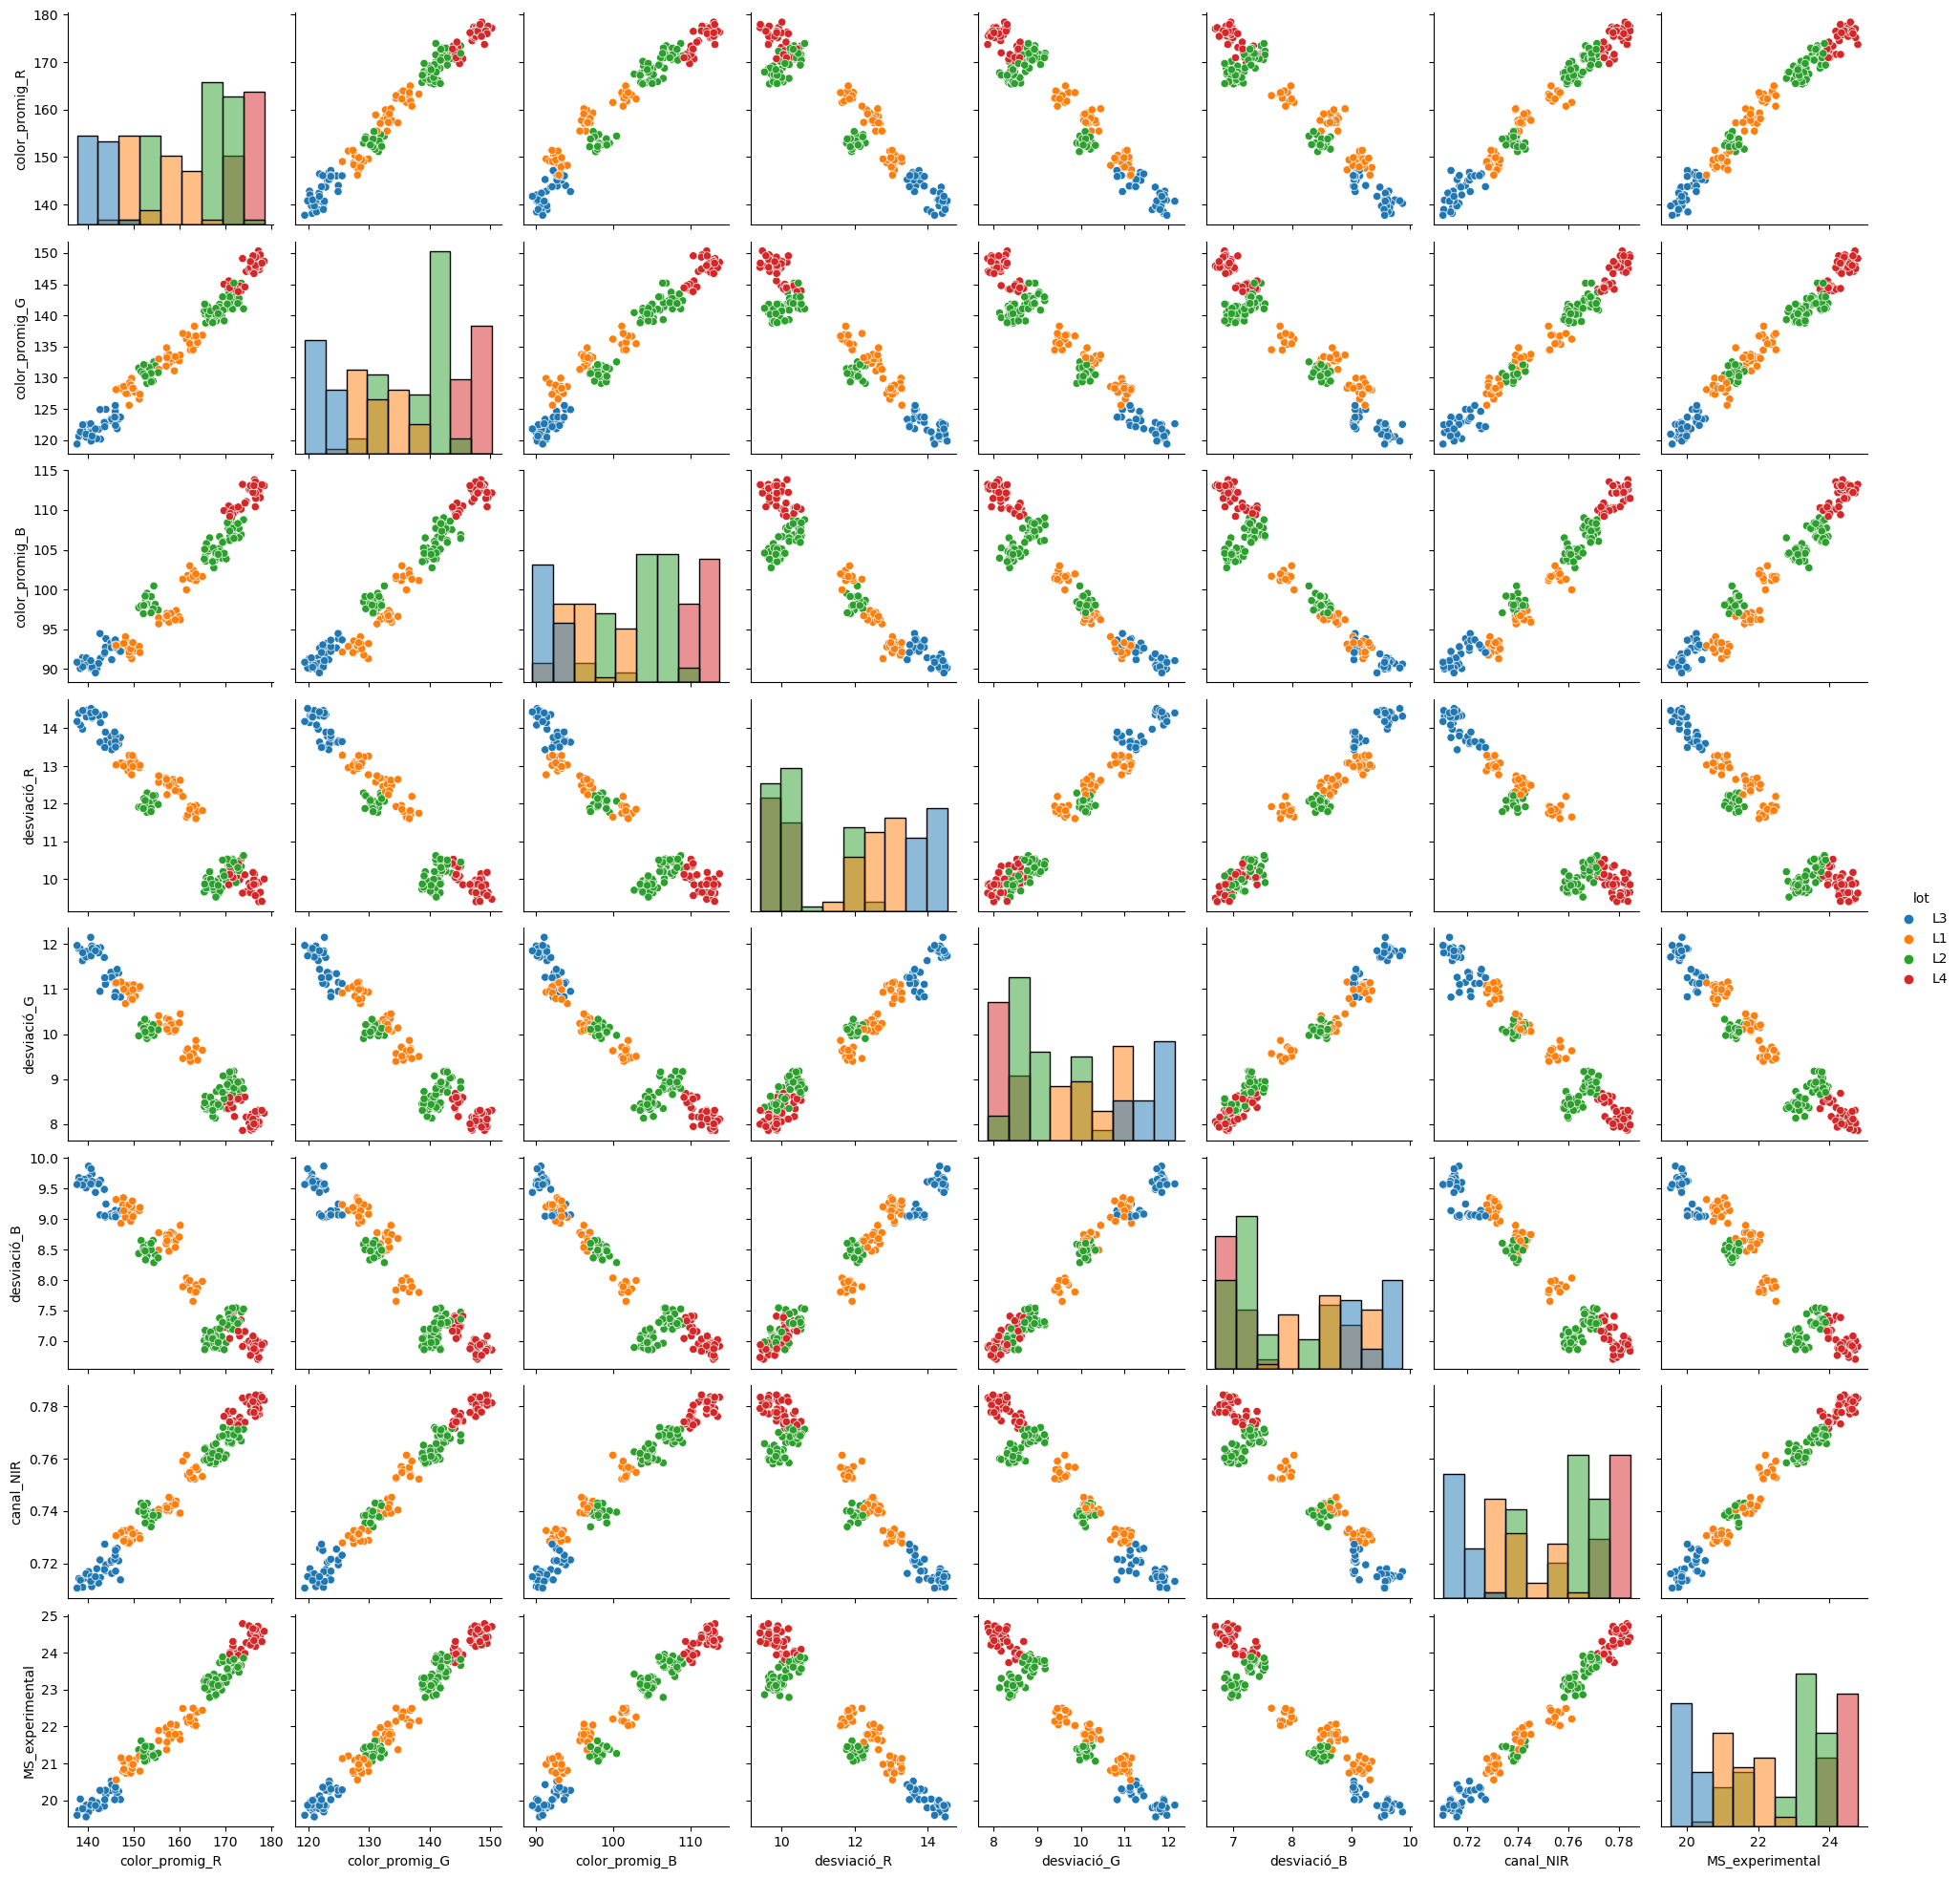

In [5]:
# Correlació entre features
sns.pairplot(
    df,
    hue="lot",          # color segons el lot
    diag_kind="hist",   # opcional: histogrames a la diagonal
)

Visualitzem més d'aprop la relació entre MS i NIR per veure si té forma d'alguna funció

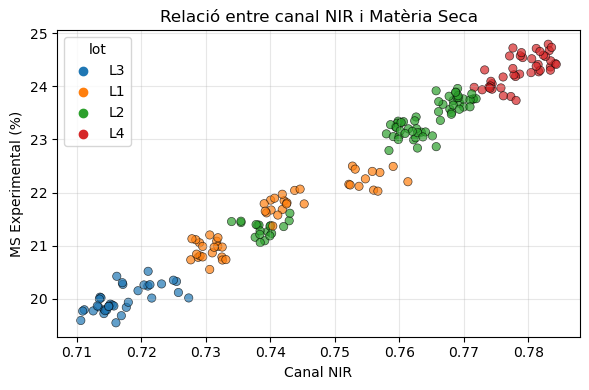

In [6]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='canal_NIR', y='MS_experimental', hue='lot', edgecolor='black', alpha=0.7)
plt.xlabel('Canal NIR')
plt.ylabel('MS Experimental (%)')
plt.title('Relació entre canal NIR i Matèria Seca')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. PREPARACIÓ DE LES DADES


In [7]:
# Seleccionar les columnes d'entrada (features) i sortida (target)
feature_cols = ['color_promig_R', 'color_promig_G', 'color_promig_B',
                'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR']
target_col = 'MS_experimental'

# Extreure X (inputs) i y (target)
X = df[feature_cols].values
y = df[target_col].values

print("\n=== PREPARACIÓ DE DADES ===\n")
print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")

# Separar en conjunt d'entrenament (80%) i validació (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"\nConjunt d'entrenament: {X_train.shape[0]} mostres")
print(f"Conjunt de validació: {X_val.shape[0]} mostres")

# Normalització (StandardScaler)
# És important normalitzar per ajudar a la xarxa neuronal a convergir millor
scaler_X = MinMaxScaler(feature_range=(-1, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.fit_transform(X_val)

print("\n\n=== NORMALITZACIÓ COMPLETADA ===\n")

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
print("Primeres files de X_train (normalitzat):")
X_train_scaled_df.head(10)


=== PREPARACIÓ DE DADES ===

Shape de X (features): (200, 7)
Shape de y (target): (200,)

Conjunt d'entrenament: 160 mostres
Conjunt de validació: 40 mostres


=== NORMALITZACIÓ COMPLETADA ===

Primeres files de X_train (normalitzat):


,color_promig_R,color_promig_G,color_promig_B,desviació_R,desviació_G,desviació_B,canal_NIR
0,0.660528,0.451657,0.421125,-0.557472,-0.494008,-0.470157,0.609601
1,0.890719,0.766114,0.938675,-0.822161,-0.931690,-0.891486,0.817560
2,0.522409,0.447096,0.288008,-0.907946,-0.752148,-0.884960,0.335021
3,0.474042,0.289072,0.163788,-0.863216,-0.768244,-0.752481,0.285515
4,0.870736,0.909715,0.918851,-0.907208,-0.829275,-0.829358,0.915737
5,0.129770,0.144868,-0.030414,0.089238,-0.255054,-0.249327,0.314120
6,0.755167,0.666337,0.430380,-0.635089,-0.494478,-0.511648,0.523404
7,-0.750423,-0.948928,-0.850061,0.853446,0.892809,0.854091,-0.891084
8,0.560697,0.386597,0.361681,-0.688407,-0.435230,-0.624154,0.662922
9,0.480514,0.371645,0.229489,-0.788678,-0.738588,-0.761246,0.416210


## 4. DEFINICIÓ DEL MODEL


In [8]:
# Funció MAPE personalitzada per Keras
def mape_metric(y_true, y_pred):
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, 1e10))
    return 100. * tf.reduce_mean(diff)

def crear_model(n_features, arquitectura=[64, 32, 16], 
                learning_rate=0.001, dropout_rate=0.2, seed=42):
    """
    Crea una xarxa neuronal densa per regressió amb arquitectura flexible.
    
    Paràmetres:
    -----------
    n_features : int
        Nombre de features d'entrada
    arquitectura : list
        Llista amb el nombre de neurones per cada capa oculta
        Exemple: [64, 128, 20, 10] crea 4 capes amb 64, 128, 20 i 10 neurones
    learning_rate : float
        Taxa d'aprenentatge per Adam
    dropout_rate : float
        Taxa de dropout per regularització (s'aplica després de cada capa)
    seed : int
        Seed per reproducibilitat
    
    Retorna:
    --------
    model : keras.Model
        Model compilat
    """
    
    model = keras.Sequential()
    
    # Capa d'entrada
    model.add(layers.Input(shape=(n_features,)))
    
    # Afegir capes ocultes segons l'arquitectura especificada
    for i, n_neurons in enumerate(arquitectura):
        model.add(layers.Dense(
            n_neurons, 
            activation='relu',
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed + i),
            bias_initializer=keras.initializers.Zeros(),
            name=f'hidden_{i+1}'
        ))
        model.add(layers.Dropout(
            dropout_rate, 
            seed=seed + i + 100,  # Seed diferent per cada dropout
            name=f'dropout_{i+1}'
        ))
    
    # Capa de sortida (regressió, 1 neurona sense activació)
    model.add(layers.Dense(
        1,
        kernel_initializer=keras.initializers.GlorotUniform(seed=seed + 1000),
        bias_initializer=keras.initializers.Zeros(),
        name='output'
    ))
    
    # Compilar el model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error per regressió
        metrics=[mape_metric]  # MAPE com a mètrica
    )
    
    return model

n_features = X_train.shape[1]

## 5. GRIDSEARCH PER TROBAR LA MILLOR CONFIGURACIÓ


In [9]:
import json
from datetime import datetime
from IPython.display import clear_output

# Crear directori per guardar checkpoints dins de RUTA_OUTPUT
checkpoints_dir = os.path.join(RUTA_OUTPUT, 'checkpoints')
os.makedirs(checkpoints_dir, exist_ok=True)

def gridsearch_amb_checkpoints(X_train, y_train, X_val, y_val, configuracions, 
                                epochs_display=10, seed=42):
    """
    Cerca manual de la millor configuració d'hiperparàmetres amb checkpoints.
    
    Paràmetres:
    -----------
    configuracions : list of dict
        Llista de diccionaris amb diferents configuracions a provar
        Cada config ha de tenir: 'arquitectura', 'learning_rate', 'dropout_rate', 'epochs'
    epochs_display : int
        Mostrar informació cada N èpoques (per defecte: 10)
    seed : int
        Seed per reproducibilitat
    
    Retorna:
    --------
    millor_config : dict
        Millor configuració trobada
    resultats : list
        Resultats de totes les configuracions
    """
    resultats = []
    
    print("\n" + "="*70)
    print("INICI DEL GRIDSEARCH")
    print("="*70)
    
    for i, config in enumerate(configuracions):
        
        print(f"\n{'='*70}")
        print(f"CONFIGURACIÓ {i+1}/{len(configuracions)}")
        print(f"{'='*70}")
        print(f"Arquitectura: {config['arquitectura']}")
        print(f"Learning rate: {config['learning_rate']}")
        print(f"Dropout rate: {config['dropout_rate']}")
        print(f"Batch size: {config.get('batch_size', 16)}")
        print(f"Epochs: {config.get('epochs', 200)}")
        
        # Crear nom únic per aquesta configuració
        config_name = f"config_{i+1}_arch_{'_'.join(map(str, config['arquitectura']))}"
        checkpoint_path = os.path.join(checkpoints_dir, f"{config_name}.h5")
        
        # Crear i entrenar model amb seed
        model_temp = crear_model(
            n_features, 
            arquitectura=config['arquitectura'],
            learning_rate=config['learning_rate'],
            dropout_rate=config['dropout_rate'],
            seed=seed  # Passar seed al model
        )
        
        # Callback personalitzat per mostrar progress cada N èpoques
        class DisplayCallback(keras.callbacks.Callback):
            def __init__(self, display_freq=epochs_display):
                self.display_freq = display_freq
                
            def on_epoch_end(self, epoch, logs=None):
                if (epoch + 1) % self.display_freq == 0:
                    print(f"Època {epoch+1}/{self.params['epochs']}: "
                          f"loss={logs['loss']:.4f}, MAPE={logs['mape_metric']:.2f}%, "
                          f"val_loss={logs['val_loss']:.4f}, val_MAPE={logs['val_mape_metric']:.2f}%")
        
        # Callbacks per aquest entrenament
        callbacks_temp = [
            EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True, 
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=0
            ),
            keras.callbacks.ModelCheckpoint(
                checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=0
            ),
            DisplayCallback(display_freq=epochs_display)
        ]
        
        # Entrenar
        print(f"\nEntrenant...")
        history_temp = model_temp.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config.get('epochs', 200),
            batch_size=config.get('batch_size', 16),
            callbacks=callbacks_temp,
            verbose=0,
            shuffle=True  # Important: shuffle amb seed fixada dona resultats reproduïbles
        )
        
        # Carregar el millor model guardat
        model_temp = keras.models.load_model(checkpoint_path, custom_objects={'mape_metric': mape_metric})
        
        # Avaluar amb el conjunt de validació
        y_pred = model_temp.predict(X_val, verbose=0).flatten()
        
        # Calcular mètriques
        mape_temp = mean_absolute_percentage_error(y_val, y_pred)
        rmse_temp = np.sqrt(mean_squared_error(y_val, y_pred))
        mae_temp = np.mean(np.abs(y_val - y_pred))
        r2_temp = r2_score(y_val, y_pred)
        
        # Guardar resultats
        resultat = {
            'config_id': i + 1,
            'config': config,
            'checkpoint_path': checkpoint_path,
            'mape': mape_temp,
            'rmse': rmse_temp,
            'mae': mae_temp,
            'r2': r2_temp,
            'val_loss_final': min(history_temp.history['val_loss']),
            'epochs_entrenats': len(history_temp.history['loss']),
            
            # Guardar l'historial complet per a plots posteriors
            'history_loss': [float(x) for x in history_temp.history['loss']],
            'history_val_loss': [float(x) for x in history_temp.history['val_loss']],
            'history_mape': [float(x) for x in history_temp.history['mape_metric']],
            'history_val_mape': [float(x) for x in history_temp.history['val_mape_metric']],
        }
        resultats.append(resultat)
        
        print(f"\n{'─'*70}")
        print(f"RESULTATS CONFIG {i+1}:")
        print(f"  MAPE: {mape_temp*100:.2f}%")
        print(f"  RMSE: {rmse_temp:.3f}")
        print(f"  MAE: {mae_temp:.3f}")
        print(f"  R²: {r2_temp:.3f}")
        print(f"  Èpoques entrenades: {len(history_temp.history['loss'])}")
        print(f"{'─'*70}")
    
    # Trobar la millor configuració (menor MAPE)
    millor = min(resultats, key=lambda x: x['mape'])
    
    print(f"\n{'='*70}")
    print("MILLOR CONFIGURACIÓ TROBADA")
    print(f"{'='*70}")
    print(f"Config ID: {millor['config_id']}")
    print(f"Arquitectura: {millor['config']['arquitectura']}")
    print(f"Learning rate: {millor['config']['learning_rate']}")
    print(f"Dropout rate: {millor['config']['dropout_rate']}")
    print(f"\nMÈTRIQUES:")
    print(f"  MAPE: {millor['mape']*100:.2f}%")
    print(f"  RMSE: {millor['rmse']:.3f}")
    print(f"  MAE: {millor['mae']:.3f}")
    print(f"  R²: {millor['r2']:.3f}")
    print(f"\nCheckpoint: {millor['checkpoint_path']}")
    print(f"{'='*70}\n")
    
    # Guardar tots els resultats en un JSON
    resultats_path = os.path.join(checkpoints_dir, 'resultats_gridsearch.json')
    with open(resultats_path, 'w') as f:
        # Convertir a format serialitzable
        resultats_serialitzable = []
        for r in resultats:
            r_copy = r.copy()
            # Escalars
            for key in ['mape', 'rmse', 'mae', 'r2', 'val_loss_final']:
                r_copy[key] = float(r_copy[key])
            # Llistes d'historial
            for key in ['history_loss', 'history_val_loss', 'history_mape', 'history_val_mape']:
                r_copy[key] = [float(x) for x in r_copy[key]]
            resultats_serialitzable.append(r_copy)
        
        json.dump({
            'data_execucio': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'seed': seed,
            'millor_config_id': millor['config_id'],
            'resultats': resultats_serialitzable
        }, f, indent=2)
    
    print(f"✓ Resultats guardats a '{resultats_path}'\n")
    
    return millor, resultats



# Definir les configuracions a provar
configuracions = [
    # Configuracions simples (poques capes, poques neurones)
    {
        'arquitectura': [32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'batch_size': 3,
        'epochs': 200
    },
    {
        'arquitectura': [64, 32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'batch_size': 3,
        'epochs': 400
    },
]

print(f"\nS'executarà GridSearch amb {len(configuracions)} configuracions diferents")
print(f"Seed de reproducibilitat: {seed}")

# EXECUTAR GRIDSEARCH
millor_config, tots_resultats = gridsearch_amb_checkpoints(
    X_train_scaled, y_train, 
    X_val_scaled, y_val,
    configuracions,
    epochs_display=10,
    seed=seed  # Passar seed al gridsearch
)


S'executarà GridSearch amb 2 configuracions diferents
Seed de reproducibilitat: 42

INICI DEL GRIDSEARCH

CONFIGURACIÓ 1/2
Arquitectura: [32, 16]
Learning rate: 0.001
Dropout rate: 0.1
Batch size: 3
Epochs: 200

Entrenant...
Època 10/200: loss=40.0836, MAPE=23.88%, val_loss=20.9063, val_MAPE=15.84%
Època 20/200: loss=14.0908, MAPE=13.64%, val_loss=4.1607, val_MAPE=7.57%
Època 30/200: loss=10.6426, MAPE=11.63%, val_loss=1.3573, val_MAPE=4.31%
Època 40/200: loss=9.9308, MAPE=11.47%, val_loss=0.9628, val_MAPE=3.58%
Època 50/200: loss=8.7047, MAPE=10.34%, val_loss=1.4103, val_MAPE=4.61%
Època 60/200: loss=9.1322, MAPE=11.18%, val_loss=0.3010, val_MAPE=1.98%
Època 70/200: loss=8.5836, MAPE=10.70%, val_loss=0.3333, val_MAPE=2.10%
Època 80/200: loss=10.7147, MAPE=11.41%, val_loss=0.2884, val_MAPE=1.92%
Època 90/200: loss=8.5527, MAPE=10.22%, val_loss=0.3559, val_MAPE=2.19%

──────────────────────────────────────────────────────────────────────
RESULTATS CONFIG 1:
  MAPE: 1.73%
  RMSE: 0.488


## 6. CARREGAR I AVALUAR EL MILLOR MODEL


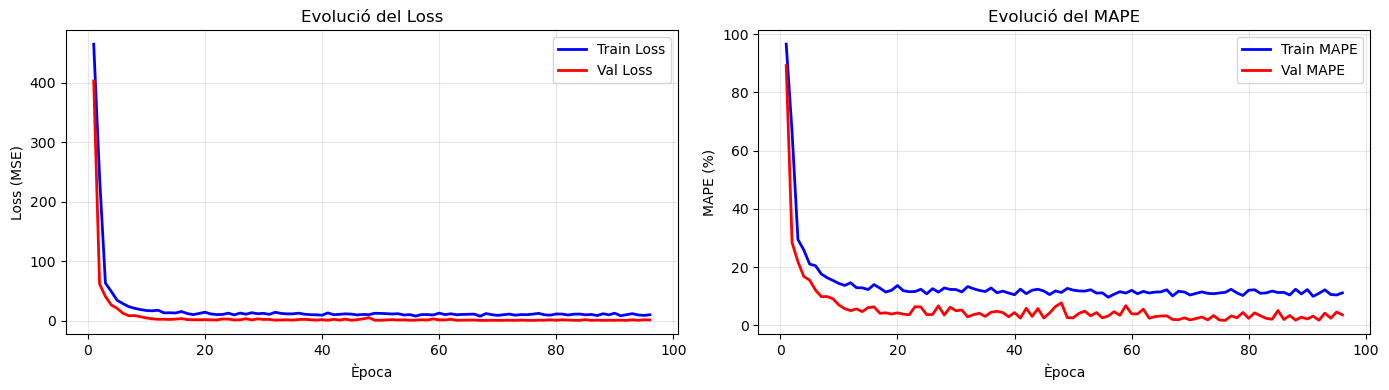

MILLOR ÈPOCA (segons val_loss): 76/96
loss: 10.7604 - MAPE: 11.34% - val_loss: 0.2201 - val_MAPE: 1.70%


In [10]:
# Paràmetre: cada quantes èpoques s'actualitza l'animació
FRAME_STEP = 1  # p.ex. 1 (cada època), 5 (cada 5 èpoques), 10, ...

# Carregar el millor model (sense re-entrenar)
millor_model = keras.models.load_model(
    millor_config['checkpoint_path'], 
    custom_objects={'mape_metric': mape_metric}
)

# Recuperar l'historial guardat durant el gridsearch
train_loss_history = millor_config['history_loss']
val_loss_history = millor_config['history_val_loss']
train_mape_history = millor_config['history_mape']
val_mape_history = millor_config['history_val_mape']

total_epochs = len(train_loss_history)

# Animació simple recorrent les èpoques
for epoch in range(total_epochs):
    # Només actualitzem el plot si toca segons FRAME_STEP
    # o si és l'última època (per assegurar que la veiem)
    if (epoch % FRAME_STEP != 0) and (epoch != total_epochs - 1):
        continue

    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    epochs_range = range(1, epoch + 2)
    
    # Loss
    ax1.plot(epochs_range, train_loss_history[:epoch+1], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_range, val_loss_history[:epoch+1], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Època')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Evolució del Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # MAPE
    ax2.plot(epochs_range, train_mape_history[:epoch+1], 'b-', label='Train MAPE', linewidth=2)
    ax2.plot(epochs_range, val_mape_history[:epoch+1], 'r-', label='Val MAPE', linewidth=2)
    ax2.set_xlabel('Època')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('Evolució del MAPE')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar informació de l'època NOMÉS si no és l'última
    if epoch < total_epochs - 1:
        print(f"Època {epoch+1}/{total_epochs} - "
              f"loss: {train_loss_history[epoch]:.4f} - "
              f"MAPE: {train_mape_history[epoch]:.2f}% - "
              f"val_loss: {val_loss_history[epoch]:.4f} - "
              f"val_MAPE: {val_mape_history[epoch]:.2f}%")

# Un cop acabada l'animació, calculem la millor època (segons val_loss)
best_epoch = min(range(total_epochs), key=lambda i: val_loss_history[i])

print("=" * 70)
print(f"MILLOR ÈPOCA (segons val_loss): {best_epoch + 1}/{total_epochs}")
print(f"loss: {train_loss_history[best_epoch]:.4f} - "
      f"MAPE: {train_mape_history[best_epoch]:.2f}% - "
      f"val_loss: {val_loss_history[best_epoch]:.4f} - "
      f"val_MAPE: {val_mape_history[best_epoch]:.2f}%")
print("=" * 70)

## 7. AVALUACIÓ FINAL DEL MILLOR MODEL I VISUALITZACIÓ DE PREDICCIONS



RESULTATS FINALS EN EL CONJUNT DE VALIDACIÓ
MAPE (Mean Absolute Percentage Error): 1.65%
RMSE (Root Mean Squared Error): 0.469
MAE (Mean Absolute Error): 0.378
R² (Coeficient de determinació): 0.894

=== INTERPRETACIÓ ===
✓ Excel·lent! MAPE < 15% - El model és molt precís

GENERANT DATAFRAME AMB PREDICCIONS DEL VALIDATION SET
✓ Prediccions del validation set guardades a 'C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2\validation_set_predictions.csv'

MAPE I MAE PER LOT EN EL CONJUNT DE VALIDACIÓ
Lot L1: MAPE = 1.05%, MAE = 0.226 (n=13 mostres)
Lot L2: MAPE = 2.23%, MAE = 0.518 (n=14 mostres)
Lot L3: MAPE = 1.06%, MAE = 0.213 (n=4 mostres)
Lot L4: MAPE = 1.87%, MAE = 0.452 (n=9 mostres)

Primeres 10 files del dataframe de validació amb prediccions:


,lot,MS_experimental,MS_predit,Error_absolut,Error_percentual
id_mostra,,,,,
10,L2,23.506946,23.145016,0.361930,1.539674
16,L1,20.736047,20.558523,0.177524,0.856112
17,L2,21.268760,20.447332,0.821428,3.862134
19,L1,20.782921,20.652885,0.130036,0.625685
31,L4,24.410349,25.007811,0.597461,2.447575
46,L4,24.271926,24.822355,0.550429,2.267761
56,L2,23.199958,23.544666,0.344709,1.485815
57,L4,24.093759,23.790546,0.303213,1.258471
61,L1,20.788871,20.761127,0.027743,0.133452


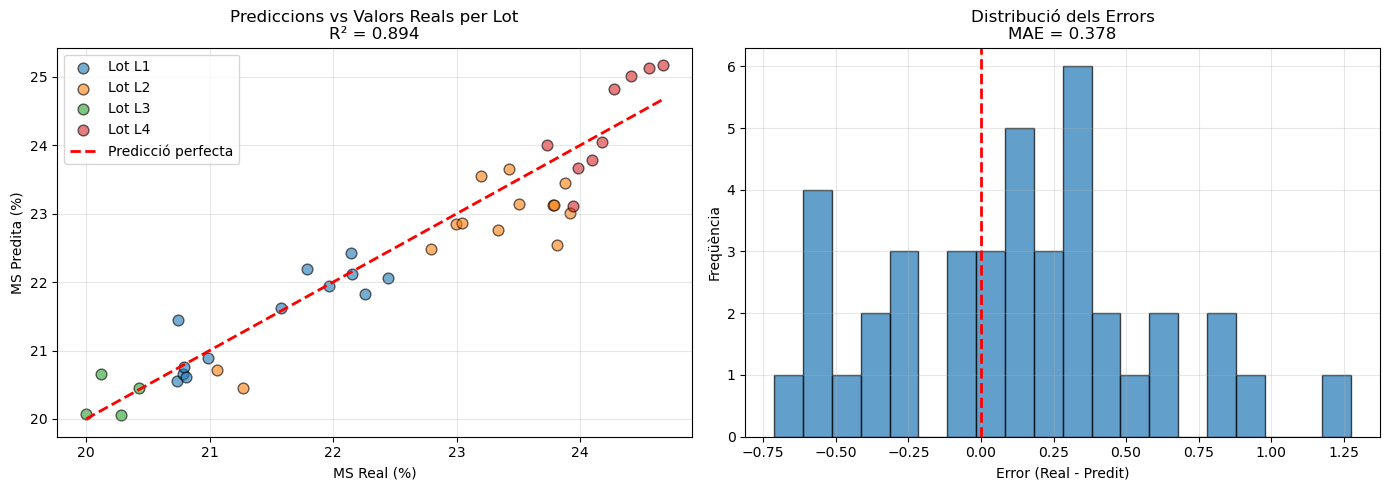

In [11]:
# Prediccions en el conjunt de validació (normalitzat)
y_val_pred = millor_model.predict(X_val_scaled, verbose=0).flatten()

# Calcular mètriques generals
mape = mean_absolute_percentage_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = np.mean(np.abs(y_val - y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("\n" + "="*70)
print("RESULTATS FINALS EN EL CONJUNT DE VALIDACIÓ")
print("="*70)
print(f"MAPE (Mean Absolute Percentage Error): {mape*100:.2f}%")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"MAE (Mean Absolute Error): {mae:.3f}")
print(f"R² (Coeficient de determinació): {r2:.3f}")
print("="*70)

# Interpretació dels resultats
print("\n=== INTERPRETACIÓ ===")
if mape < 0.15:
    print("✓ Excel·lent! MAPE < 15% - El model és molt precís")
elif mape < 0.20:
    print("✓ Acceptable. MAPE entre 15-20% - El model és força bo")
else:
    print("✗ Millorable. MAPE > 20% - Caldria més dades o millor preprocessament")

# CREAR DATAFRAME AMB ELS RESULTATS DEL VALIDATION SET
print("\n" + "="*70)
print("GENERANT DATAFRAME AMB PREDICCIONS DEL VALIDATION SET")
print("="*70)

# Obtenir els índexs originals del validation set
indices_originals = df.index.values
_, indices_val = train_test_split(
    indices_originals, test_size=0.2, random_state=seed
)

# Crear dataframe amb les dades originals del validation set
df_val_resultats = df.loc[indices_val].copy()

# Afegir la columna de predicció
df_val_resultats['MS_predit'] = y_val_pred

# Calcular l'error per cada mostra
df_val_resultats['Error_absolut'] = np.abs(
    df_val_resultats['MS_experimental'] - df_val_resultats['MS_predit']
)
df_val_resultats['Error_percentual'] = (
    df_val_resultats['Error_absolut'] / df_val_resultats['MS_experimental'] * 100
)

# Reordenar columnes per tenir MS_experimental i MS_predit juntes
columnes_ordenades = [col for col in df_val_resultats.columns 
                      if col not in ['MS_predit', 'Error_absolut', 'Error_percentual']]
columnes_ordenades.insert(
    columnes_ordenades.index('MS_experimental') + 1, 
    'MS_predit'
)
columnes_ordenades.extend(['Error_absolut', 'Error_percentual'])
df_val_resultats = df_val_resultats[columnes_ordenades]

# ORDENAR PER INDEX
df_val_resultats = df_val_resultats.sort_index()

# Guardar el dataframe com a CSV
ruta_csv_validacio = os.path.join(RUTA_OUTPUT, 'validation_set_predictions.csv')
df_val_resultats.to_csv(ruta_csv_validacio, index=True)
print(f"✓ Prediccions del validation set guardades a '{ruta_csv_validacio}'")

# CALCULAR MAPE I MAE PER LOT
print("\n" + "="*70)
print("MAPE I MAE PER LOT EN EL CONJUNT DE VALIDACIÓ")
print("="*70)
for lot in sorted(df_val_resultats['lot'].unique()):
    df_lot = df_val_resultats[df_val_resultats['lot'] == lot]
    mape_lot = mean_absolute_percentage_error(
        df_lot['MS_experimental'], 
        df_lot['MS_predit']
    )
    mae_lot = np.mean(np.abs(df_lot['MS_experimental'] - df_lot['MS_predit']))
    n_mostres = len(df_lot)
    print(f"Lot {lot}: MAPE = {mape_lot*100:.2f}%, MAE = {mae_lot:.3f} (n={n_mostres} mostres)")
print("="*70)

# Mostrar primeres files del dataframe
print(f"\nPrimeres 10 files del dataframe de validació amb prediccions:")
display(df_val_resultats.head(10)[['lot', 'MS_experimental', 'MS_predit', 
                                     'Error_absolut', 'Error_percentual']])

# GRÀFICS DE VISUALITZACIÓ
fig = plt.figure(figsize=(14, 5))

# Gràfic de dispersió: valor real vs predit amb colors per lot
ax1 = plt.subplot(1, 2, 1)
lots_unics = sorted(df_val_resultats['lot'].unique())

# Crear paleta de colors consistent amb seaborn (com al pairplot de la cel·la 2)
colors = sns.color_palette("tab10", n_colors=len(lots_unics))

for i, lot in enumerate(lots_unics):
    mask = df_val_resultats['lot'] == lot
    y_val_lot = df_val_resultats.loc[mask, 'MS_experimental'].values
    y_pred_lot = df_val_resultats.loc[mask, 'MS_predit'].values
    plt.scatter(y_val_lot, y_pred_lot, alpha=0.6, edgecolor='black', 
                color=colors[i], label=f'Lot {lot}', s=60)

plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', linewidth=2, label='Predicció perfecta')
plt.xlabel('MS Real (%)')
plt.ylabel('MS Predita (%)')
plt.title(f'Prediccions vs Valors Reals per Lot\nR² = {r2:.3f}')
plt.legend(loc='best')
plt.grid(alpha=0.3)

# Distribució dels errors
ax2 = plt.subplot(1, 2, 2)
errors = y_val - y_val_pred
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Error (Real - Predit)')
plt.ylabel('Freqüència')
plt.title(f'Distribució dels Errors\nMAE = {mae:.3f}')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUTA_OUTPUT, 'validation_predictions_plot.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

## 8. GUARDAR EL MILLOR MODEL I SCALERS


In [12]:
# Guardar el millor model amb un nom descriptiu (format .h5 per compatibilitat)
nom_model_final = f"model_prediccio_ms_final_MAPE_{mape*100:.2f}.h5"
ruta_model_final = os.path.join(RUTA_OUTPUT, nom_model_final)
millor_model.save(ruta_model_final)
print(f"\n✓ Millor model guardat com '{ruta_model_final}'")

# També guardar una còpia com a model per defecte
ruta_model_defecte = os.path.join(RUTA_OUTPUT, 'model_prediccio_ms.h5')
millor_model.save(ruta_model_defecte)
print(f"✓ Còpia guardada com '{ruta_model_defecte}'")

# Guardar els scalers amb pickle
ruta_scaler_X = os.path.join(RUTA_OUTPUT, 'scaler_X.pkl')

import pickle
with open(ruta_scaler_X, 'wb') as f:
    pickle.dump(scaler_X, f)
print(f"✓ Scaler guardat com '{ruta_scaler_X}'")

# Guardar informació del millor model
info_model = {
    'seed': seed,  # AFEGIT: guardar seed per reproducibilitat
    'arquitectura': millor_config['config']['arquitectura'],
    'learning_rate': millor_config['config']['learning_rate'],
    'dropout_rate': millor_config['config']['dropout_rate'],
    'batch_size': millor_config['config'].get('batch_size', 16),
    'epochs': millor_config['config'].get('epochs', 200),
    'mape': float(mape),
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2),
    'n_mostres_train': X_train.shape[0],
    'n_mostres_val': X_val.shape[0],
    'feature_cols': feature_cols,  # AFEGIT: guardar columnes utilitzades
    'data_entrenament': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

ruta_info = os.path.join(RUTA_OUTPUT, 'info_millor_model.json')
with open(ruta_info, 'w') as f:
    json.dump(info_model, f, indent=2)
print(f"✓ Informació del model guardada a '{ruta_info}'")

print("\n" + "="*70)
print("PROCÉS COMPLETAT")
print("="*70)
print(f"\nDirectori d'output: {RUTA_OUTPUT}")
print("\nArxius generats:")
print(f"  - {nom_model_final}")
print(f"  - model_prediccio_ms.h5")
print(f"  - scaler_X.pkl")
print(f"  - info_millor_model.json (inclou seed={seed})")
print(f"  - validation_set_predictions.csv")
print(f"  - validation_predictions_plot.png")
print(f"  - checkpoints/ (directori amb tots els checkpoints en format .h5)")
print(f"  - checkpoints/resultats_gridsearch.json (inclou seed={seed})")
print("\nPer carregar el model en el futur:")
print(f"  model = keras.models.load_model('{ruta_model_defecte}', ")
print(f"                                   custom_objects={{'mape_metric': mape_metric}})")
print(f"  with open('{ruta_scaler_X}', 'rb') as f: scaler_X = pickle.load(f)")
print(f"\nRECORDA: Aquest model s'ha entrenat amb seed={seed} per reproducibilitat total")
print("="*70)


✓ Millor model guardat com 'C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2\model_prediccio_ms_final_MAPE_1.65.h5'
✓ Còpia guardada com 'C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2\model_prediccio_ms.h5'
✓ Scaler guardat com 'C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2\scaler_X.pkl'
✓ Informació del model guardada a 'C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2\info_millor_model.json'

PROCÉS COMPLETAT

Directori d'output: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/output/test_run_2

Arxius generats:
  - model_prediccio_ms_final_MAPE_1.65.h5
  - model_prediccio_ms.h5
  - scaler_X.pkl
  - info_millor_model.json (inclou seed=42)
  - validation_set_predictions.csv
  - validation_predictions_plot.png
  - checkpoints/ (directori amb tots els checkpoints en format .h5)
  - checkpoints/resultats_gridsearch.json (inclou seed=42)

Per carregar el m